<a href="https://colab.research.google.com/github/Tasleem1027/OPTIMISATION_TEC1/blob/main/blloddonation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Load data
df = pd.read_csv("/content/blood.csv")

# Drop personal or non-predictive columns
df = df.drop(columns=["donor_id", "name", "email", "password", "contact_number"])

# Encode categorical columns
label_encoders = {}
for col in ["city", "blood_group", "availability"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Split into features and target
X = df.drop(columns=["availability"])
y = df["availability"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM model
svm_model = SVC(kernel="rbf", C=10, gamma=0.1)
svm_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = svm_model.predict(X_test_scaled)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.491
              precision    recall  f1-score   support

           0       0.48      0.38      0.42       983
           1       0.50      0.60      0.54      1017

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.48      2000
weighted avg       0.49      0.49      0.48      2000



Best C: 0.1
Best Accuracy: 0.51


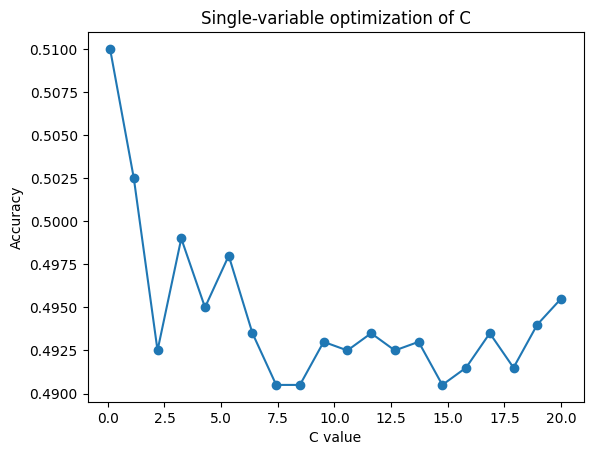

In [ ]:
import numpy as np

# Range of C values to try
C_values = np.linspace(0.1, 20, 20)  # 20 values between 0.1 and 20
accuracies = []

for C in C_values:
    model = SVC(kernel="rbf", C=C, gamma=0.1)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Find the C with highest accuracy
best_idx = np.argmax(accuracies)
best_C = C_values[best_idx]
best_acc = accuracies[best_idx]

print("Best C:", best_C)
print("Best Accuracy:", best_acc)

# Optionally plot
import matplotlib.pyplot as plt
plt.plot(C_values, accuracies, marker="o")
plt.xlabel("C value")
plt.ylabel("Accuracy")
plt.title("Single-variable optimization of C")
plt.show()


In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np

feature_names = X.columns  # original feature names
max_features = X.shape[1]  # total number of features
best_acc = 0
best_k = 0
best_features = None

for k in range(1, max_features + 1):
    # Select top k features
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_k = selector.fit_transform(X_train_scaled, y_train)
    X_test_k = selector.transform(X_test_scaled)

    # Train with best C from earlier
    model = SVC(kernel="rbf", C=best_C, gamma=0.1)
    model.fit(X_train_k, y_train)
    y_pred_k = model.predict(X_test_k)
    acc = accuracy_score(y_test, y_pred_k)

    if acc > best_acc:
        best_acc = acc
        best_k = k
        best_features = feature_names[selector.get_support()]

print("Best number of features:", best_k)
print("Best accuracy:", best_acc)
print("Best features:", list(best_features))


Best number of features: 6
Best accuracy: 0.51
Best features: ['city', 'blood_group', 'months_since_first_donation', 'number_of_donation', 'pints_donated', 'created_at']


In [ ]:
!pip install dash

In [ ]:
import pandas as pd
import plotly.express as px
from dash import Dash, dcc, html

# Load dataset
df = pd.read_csv("blood.csv")

# Prepare data
availability_counts = df["availability"].value_counts().reset_index()
availability_counts.columns = ["availability", "count"]

city_counts = df["city"].value_counts().reset_index()
city_counts.columns = ["city", "count"]

blood_group_counts = df["blood_group"].value_counts().reset_index()
blood_group_counts.columns = ["blood_group", "count"]

# App setup
app = Dash(__name__)

app.layout = html.Div([
    html.H1("Blood Donor Dashboard", style={"textAlign": "center"}),

    dcc.Graph(
        figure=px.pie(
            availability_counts,
            names="availability",
            values="count",
            title="Donor Availability"
        )
    ),

    dcc.Graph(
        figure=px.bar(
            city_counts,
            x="city",
            y="count",
            title="Donors by City",
            color="count"
        )
    ),

    dcc.Graph(
        figure=px.bar(
            blood_group_counts,
            x="blood_group",
            y="count",
            title="Blood Group Distribution",
            color="count"
        )
    ),

    dcc.Graph(
        figure=px.scatter(
            df,
            x="number_of_donation",
            y="pints_donated",
            title="Donations vs Pints Donated",
            size="pints_donated",
            color="availability"
        )
    ),

    dcc.Graph(
        figure=px.histogram(
            df,
            x="months_since_first_donation",
            title="Months Since First Donation Distribution",
            nbins=20
        )
    )
])

